 # Classification of protein families based on their sequence of aminoacids using Random Forest

This notebook is based on the work found here:

https://www.kaggle.com/danofer/protein-sequence-family-classification/notebook

Using data from:

https://www.kaggle.com/shahir/protein-data-set

Where Neural Network (NN) is used to perform the prediction. This notebook sustitutes the NN with Random Forest (RF) together with tf-idf representation showing a similar performance (accuracy: 0.63) to the most complex NN when classifing only the 10 most common families.

In [33]:
# load packages
from sklearn import model_selection, metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import ensemble
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix

from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from collections import Counter

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import pickle

In [ ]:
#Data Directory
input_dir='../Data/'
#Output Directory
output_dir='../Models/'

In [8]:
# Read and combine data sequences with family classification. Drop duplicates
df = pd.read_csv(input_dir+'pdb_data_no_dups.csv').merge(pd.read_csv(input_dir+'pdb_data_seq.csv'), how='inner', on='structureId').drop_duplicates(["sequence"]) # ,"classification"
# Drop rows with missing labels and empty sequences
df = df[[type(c) == type('') for c in df.classification.values]]
df = df[[type(c) == type('') for c in df.sequence.values]]
# Keep only proteins
df = df[df.macromoleculeType_x == 'Protein']
df.reset_index()
print(df.shape)
df.head()

(87761, 18)


,structureId,classification,experimentalTechnique,macromoleculeType_x,residueCount_x,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear,chainId,sequence,residueCount_y,macromoleculeType_y
4,101M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,2.07,18112.80,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154,Protein
7,102L,HYDROLASE(O-GLYCOSYL),X-RAY DIFFRACTION,Protein,165,1.74,18926.61,NaN,NaN,2.75,55.28,NaN,NaN,1993.0,A,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...,165,Protein
8,102M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,1.84,18010.64,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154,Protein
11,103L,HYDROLASE(O-GLYCOSYL),X-RAY DIFFRACTION,Protein,167,1.90,19092.72,NaN,NaN,2.70,54.46,NaN,NaN,1993.0,A,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...,167,Protein
15,104L,HYDROLASE(O-GLYCOSYL),X-RAY DIFFRACTION,Protein,332,2.80,37541.04,NaN,NaN,3.04,59.49,NaN,NaN,1993.0,A,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSAA...,332,Protein


In [9]:
#Model Building
def train_model(classifier, feature_vector_train, label, feature_vector_valid, valid_y, is_neural_net=False, return_model=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    if return_model:
        return (metrics.accuracy_score(predictions, valid_y),classifier)
    else:
        return metrics.accuracy_score(predictions, valid_y)

In [10]:
#Select only protein in the top classes
top_classes=10
cnt = Counter(df.classification)
most_common_classes = cnt.most_common()[:top_classes]
most_common_classes = [c[0] for c in most_common_classes ]
df=df[df.classification.isin(most_common_classes)]

In [12]:
#Y values
lb = LabelEncoder()
Y = lb.fit_transform(df.classification)

In [17]:
# Tokenization of sequences
max_length = 300
seqs = df.sequence.values
#create and fit tokenizer
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(seqs)
#represent input data as word rank number sequences
X = tokenizer.texts_to_sequences(seqs)
X = sequence.pad_sequences(X, maxlen=max_length)
X = [ " ".join(map(str,x)) for x in X]

In [18]:
#Split datasets for train and testing
X_train, X_aux, Y_train, Y_aux= model_selection.train_test_split(X,Y,random_state=random.randint(0,1000000), test_size=0.3, stratify=Y)
X_test, X_valid, Y_test, Y_valid= model_selection.train_test_split(X_aux,Y_aux,random_state=random.randint(0,1000000), test_size=0.5, stratify=Y_aux)

In [19]:
#Conversion of tokenized sequences to tf-df n-grams and posterior reduction singular value decomposition
#Based on the sequences in the training set
max_features=20000
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1,3), max_features=max_features)
tfidf_vect_ngram.fit(X_train)
svd = TruncatedSVD(n_components=2000, n_iter=100, random_state=random.randint(0,1000000))
X_train =  svd.fit_transform(tfidf_vect_ngram.transform(X_train))
X_valid =  svd.transform(tfidf_vect_ngram.transform(X_valid))
X_test =  svd.transform(tfidf_vect_ngram.transform(X_test))

In [20]:
X_train.shape

(31913, 2000)

In [23]:
Y_train[0:10]

array([7, 8, 3, 2, 7, 7, 5, 2, 7, 7])

In [80]:
#Y_train2=[y.argmax() for y in Y_train]
#Y_test2=[y.argmax() for y in Y_test]
#Y_valid2=[y.argmax() for y in Y_valid]

In [36]:
#Training Random Forest
n_estimators=100
accuracy,rf= train_model(ensemble.RandomForestClassifier(n_estimators=n_estimators), X_train, Y_train, X_valid, Y_valid, return_model=True)
print("RF, N-Gram Vectors: ", accuracy)


RF, N-Gram Vectors:  0.6356192425793245


In [44]:
#Save model
pickle.dump(rf, open(output_dir+'random_forest.mod','wb'))
#Save encoder
pickle.dump(lb, open(output_dir+'label_encoder.pck','wb')) 
#Save Tokenizer
pickle.dump(tokenizer, open(output_dir+'/tokenizer.pck','wb')) 
#Save tfidf
pickle.dump(tfidf_vect_ngram, open(output_dir+'tfidf.pck','wb'))
#save 
pickle.dump(svd, open(output_dir/'svd.pck','wb'))

In [37]:
#Evaluate predictions on test set 
preds=rf.predict(X_test)
print("test-acc = " + str(accuracy_score(preds,Y_test)))

test-acc = 0.6411756104693669


In [42]:
cm = confusion_matrix(Y_test, preds)

In [39]:
cm

array([[1575,   38,    2,   17,   11,    7,   18,  101,    1,    4],
       [  97,  640,    0,    2,    5,    3,    7,    9,    0,    4],
       [ 117,    1,  189,   15,    3,    0,    3,   40,    0,    0],
       [ 292,   11,    1,  628,    3,    2,   11,   85,    0,    0],
       [ 111,   28,    0,    3,   52,   15,   35,   21,    5,    0],
       [ 130,   23,    0,    7,   23,  102,   39,   25,    0,    0],
       [ 128,   18,    0,    3,   18,    4,  177,   39,    0,    2],
       [ 406,   29,    2,   31,   10,    6,   30,  794,    0,    1],
       [ 132,   12,    0,    9,    3,    4,   11,   26,  121,    0],
       [  94,   18,    0,    4,    5,    3,   17,   14,    0,  107]])

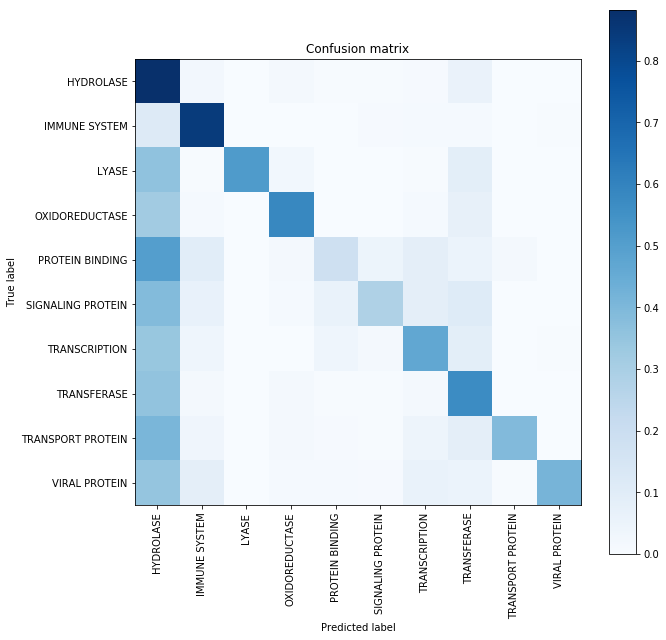

In [34]:
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
np.set_printoptions(precision=2)
plt.figure(figsize=(10,10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(lb.classes_))
plt.xticks(tick_marks, lb.classes_, rotation=90)
plt.yticks(tick_marks, lb.classes_)
#for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#    plt.text(j, i, format(cm[i, j], '.2f'), horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2. else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()